In [42]:
import numpy as np
import pandas as pd
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

plt.style.use('ggplot')

In [43]:
'''
Перед вами таблица, где числовая переменная – непрерывная. Задача – сравнить группы двумя способами: бутстрапом и u-тестом

Описание колонок
value – значения метрики
experimentVariant – Вариант теста (Control – контроль, Treatment – тест)
Задача
1. Сравните результат между тестом и контролем по двум кейсам:

Примените бутстрап (с np.mean) и критерий mann-whitney, а потом сравните p-value
Примените бутстрап (с np.median) и критерий mann-whitney, а потом сравните p-value.
2. Напишите выводы, которые можно сделать на основе анализа примененных критериев
'''

Нулевая гипотеза, что ничего не изменилось, тест и контроль равны.

Альтернативная гипотеза, тест и контроль не равны.

## Вариант 1

In [44]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

In [45]:
df_hw = pd.read_csv('/Users/ruslanhuretski/Documents/karpov.cources/Statistics/hw_bootstrap.csv', 
                    sep=';', decimal=',')

In [46]:
df_hw.head()

,Unnamed: 0,value,experimentVariant
0,1,10.380495,Control
1,2,9.546867,Control
2,3,11.088215,Control
3,4,10.147274,Control
4,5,9.789808,Control


In [47]:
df_hw.dtypes

Unnamed: 0             int64
value                float64
experimentVariant     object
dtype: object

In [48]:
df_hw.experimentVariant.value_counts()

Control      500
Treatment    500
Name: experimentVariant, dtype: int64

In [49]:
df_hw.groupby('experimentVariant').agg({'value': 'mean'})

,value
experimentVariant,
Control,10.026867
Treatment,27.321499


In [50]:
df_hw.groupby('experimentVariant').agg({'value': 'median'})

,value
experimentVariant,
Control,10.018465
Treatment,10.025847


<AxesSubplot:xlabel='experimentVariant', ylabel='value'>

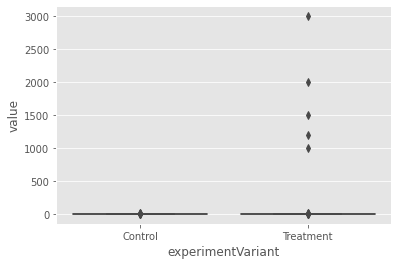

In [51]:
sns.boxplot(x="experimentVariant", y="value", data=df_hw)

In [52]:
df_hw_control = df_hw[df_hw.experimentVariant == 'Control']
df_hw_treatment = df_hw[df_hw.experimentVariant == 'Treatment']

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='value'>

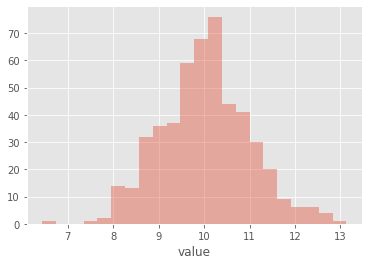

In [53]:
sns.distplot(df_hw_control.value, kde=False)

<AxesSubplot:xlabel='value'>

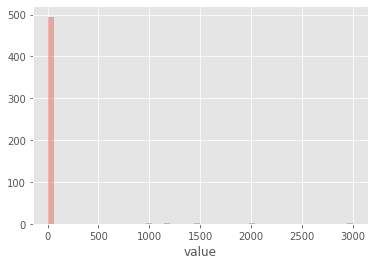

In [54]:
sns.distplot(df_hw_treatment.value, kde=False)

In [73]:
# смотрим на выбросы
df_hw_treatment[df_hw_treatment.value > 15]

,Unnamed: 0,value,experimentVariant
995,996,1000.0,Treatment
996,997,1200.0,Treatment
997,998,1500.0,Treatment
998,999,2000.0,Treatment
999,1000,3000.0,Treatment


In [56]:
# Считаем критерий mann-whitney
mannwhitneyu(df_hw_treatment.value, df_hw_control.value)

MannwhitneyuResult(statistic=125810.5, pvalue=0.8592148582485579)

  0%|          | 0/1000 [00:00<?, ?it/s]

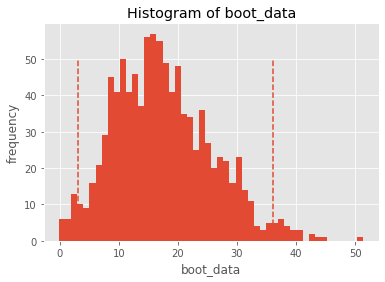

In [57]:
booted_data = get_bootstrap(
    df_hw_treatment.value, # числовые значения первой выборки
    df_hw_control.value, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)  # в результате хранится разница двух распределений, ДИ и pvalue

In [58]:
# Значение p-value для mean
booted_data["p_value"]

0.033424943504845345

In [59]:
# Доверительный интервал для mean
booted_data["ci"]

,0
0.025,3.040914
0.975,36.199494


  0%|          | 0/1000 [00:00<?, ?it/s]

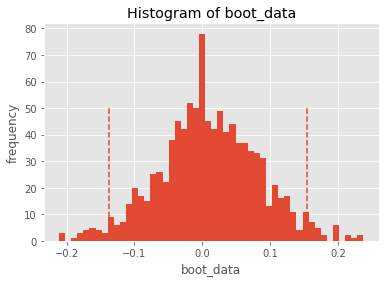

In [60]:
booted_data_median = get_bootstrap(
    df_hw_treatment.value, # числовые значения первой выборки
    df_hw_control.value, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)  # в результате хранится разница двух распределений, ДИ и pvalue

In [61]:
# Значение p-value для median
booted_data_median["p_value"]

0.886451429197653

In [62]:
# Доверительный интервал для median
booted_data_median["ci"]

,0
0.025,-0.137261
0.975,0.154532


## Вывод 1

Медиана не чувствительна к выбросам, как и критерий mann-whitney, они смотрят только на ранговый порядок. А по факту есть чувствительные выбросы (5 метрик), просто так их выкинуть не можем, т.к. они могут быть важны для бизнесса.

- Значение p-value критерия бутстрап (с np.mean) < 0.05.
- 0 не попадает в доверительный интервал. 

По этим данным нулевую гипотезу будем отклонять.

## Вариант 2

Убираем 5 выбросов из теста

In [67]:
# числовые значения теста без выбросов
df_hw_treatment_norm = df_hw_treatment[df_hw_treatment.value < 15]

In [71]:
df_hw_treatment_norm.shape

(495, 3)

<AxesSubplot:xlabel='value'>

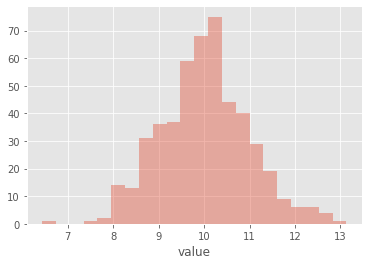

In [68]:
sns.distplot(df_hw_treatment_norm.value, kde=False)

In [69]:
# Считаем критерий mann-whitney 
mannwhitneyu(df_hw_treatment_norm.value, df_hw_control.value)

MannwhitneyuResult(statistic=123310.5, pvalue=0.9228386264147465)

  0%|          | 0/1000 [00:00<?, ?it/s]

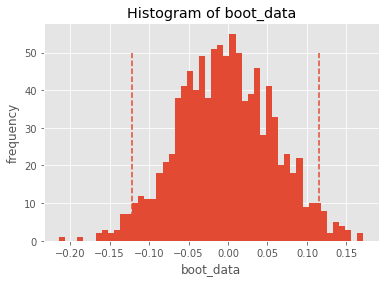

In [74]:
booted_data_norm = get_bootstrap(
    df_hw_treatment_norm.value, # числовые значения первой выборки
    df_hw_control.value, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)  # в результате хранится разница двух распределений, ДИ и pvalue

In [75]:
# Значение p-value для median
booted_data_norm["p_value"]

0.960490293132562

In [76]:
# Доверительный интервал для median
booted_data_norm["ci"]

,0
0.025,-0.122182
0.975,0.114698


## Вывод 2

Если убираем чувствительные выбросы (5 метрик), то уже и критерий бутстрап (с np.mean) не дает значимых различий, как в 1 варианте. Скорректированные данные не дают нам отклонить нулевую гипотезу о равенсте теста и контроля